# Foward Modeling of Jupiter-like Clouds and Reflection Spectrum 

In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

Sets an atmosphere model

In [2]:
from exojax.utils.grids import wavenumber_grid
N = 10000
nus, wav, res = wavenumber_grid(10**3, 10**4, N, xsmode="premodit")

from exojax.utils.constants import kB, m_u
from exojax.atm.atmprof import pressure_layer_logspace
from exojax.spec.atmrt import ArtReflectPure

art = ArtReflectPure(nu_grid=nus, pressure_btm=1.e2, pressure_top=1.e-3, nlayer=100)
art.change_temperature_range(80.0, 400.0)
Tarr = art.powerlaw_temperature(150.0,0.2)
mmr_profile = art.constant_mmr_profile(0.01)
Parr = art.pressure

#Parr, dParr, k = pressure_layer_logspace(log_pressure_top=-5., log_pressure_btm=2.0, nlayer=100)
#alpha = 0.2
#T0 = 200.
#Tarr = T0 * (Parr)**alpha

mu = 2.0  # mean molecular weight
R = kB / (mu * m_u)
rho = Parr / (R * Tarr)

g=1.e5

xsmode =  premodit
xsmode assumes ESLOG in wavenumber space: mode=premodit
The wavenumber grid should be in ascending order.
The users can specify the order of the wavelength grid by themselves.
Your wavelength grid is in ***  descending  *** order


/home/kawahara/exojax/src/exojax/utils/grids.py:142: UserWarning: Resolution may be too small. R=4342.510524550615
  warnings.warn('Resolution may be too small. R=' + str(resolution),
/home/kawahara/exojax/src/exojax/spec/dtau_mmwl.py:14: FutureWarning: dtau_mmwl might be removed in future.
  warnings.warn("dtau_mmwl might be removed in future.", FutureWarning)


`pdb` is a class for particulates databases. We here use `PdbCloud` for NH3, i.e. `pdb` for the ammonia cloud. 
PdbCloud uses the refaction (refractive) indice given by VIRGA. The Mie parameters assuming a log-normal distribution is called `miegrid`. This can be computed pdb.generate_miegrid if you do not have it. To compute `miegrid`, we use PyMieScatt as a calculator.   

Also, `amp` is a class for atmospheric micorphysics. AmpAmcloud is the class for the Akerman and Marley 2001 cloud model (AM01). We adopt the background atmosphere to hydorogen atmosphere.

In [3]:
from exojax.spec.pardb import PdbCloud
from exojax.atm.atmphys import AmpAmcloud

pdb_nh3 = PdbCloud("NH3")
pdb_nh3.load_miegrid()

amp_nh3 = AmpAmcloud(pdb_nh3,bkgatm="H2")
amp_nh3.check_temperature_range(Tarr)

.database/particulates/virga/virga.zip  exists. Remove it if you wanna re-download and unzip.
Refractive index file found:  .database/particulates/virga/NH3.refrind
Miegrid file exists: .database/particulates/virga/miegrid_lognorm_NH3.mg.npz
pdb.miegrid, pdb.rg_arr, pdb.sigmag_arr are now available. The Mie scattering computation is ready.


/home/kawahara/exojax/src/exojax/atm/atmphys.py:49: UserWarning: min temperature 80.0 K is smaller than min(vfactor t range) 179.10000610351562 K
  warnings.warn(


Sets the parameters in the AM01 cloud model. `calc_ammodel` method computes the vertical distribution of `rg` and the condensate volume mixing ratio.

In [4]:
fsed = 10.
sigmag = 2.0
Kzz = 1.e4
VMR = 0.001
rg_layer, VMRc = amp_nh3.calc_ammodel(Parr, Tarr, mu, g, fsed=fsed, sigmag=sigmag, Kzz=Kzz, VMR=VMR)

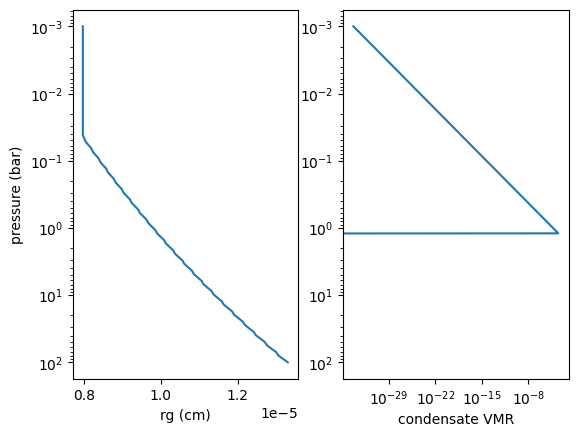

In [5]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(121)
plt.plot(rg_layer,Parr)
plt.xlabel("rg (cm)")
plt.ylabel("pressure (bar)")
plt.yscale("log")
ax.invert_yaxis()
ax = fig.add_subplot(122)
plt.plot(VMRc,Parr)
plt.xlabel("condensate VMR")
plt.yscale("log")
plt.xscale("log")
ax.invert_yaxis()

`rg` is almost constant through the vertical distribution. So, let's set a mean value here. `miegrid_interpolated_value` method interpolates the original parameter set given by MiQ_lognormal in PyMieScatt. See https://pymiescatt.readthedocs.io/en/latest/forward.html#Mie_Lognormal. The number of the original parameters are seven, Bext, Bsca, Babs, G, Bpr, Bback, and Bratio. 

In [6]:
#rg = 8e-4
rg = 1e-5
mieQpar = pdb_nh3.miegrid_interpolated_values(rg, sigmag)
#beta0, omega, g = pdb_nh3.(rg,sigmag)


Plots the extinction coefficient for instance (index=0) and some approximation from the Kevin Heng's textbook .

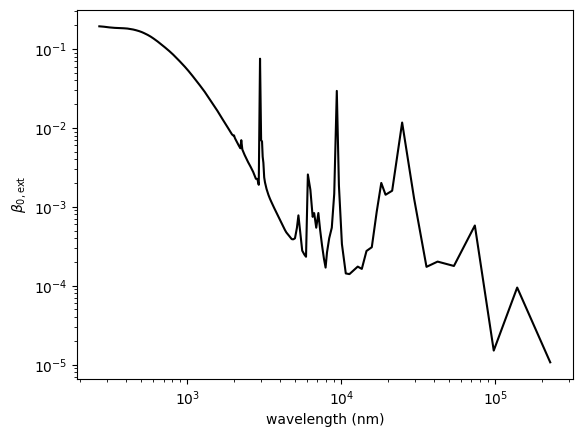

In [7]:
import numpy as np
# approximate model (i.e. Heng's textbook)
#x = 2*np.pi*(rg*np.exp(np.log(sigmag)**2/2.0))/(pdb_nh3.refraction_index_wavelength_nm*1.e-7)
#Q0 = 10.
#qe = 5/(Q0*x**-4 + x**0.2)*0.1

fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(pdb_nh3.refraction_index_wavelength_nm, np.real(mieQpar[:,0]),color="black")  #Bext, Bsca, Babs, G, Bpr, Bback, Bratio
#plt.plot(pdb_nh3.refraction_index_wavelength_nm, qe, ls="dashed")
#plt.ylim(1.e-5,1.e0)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("wavelength (nm)")
plt.ylabel("$\\beta_{0, \mathrm{ext}}$")
plt.savefig("miefig.png")

To handle the opacity for Mie scattering, we call `OpaMie` class as `opa`.  
The mie parameters can be derived by `mieparams_vector` method, which returns $\beta_0$: the extinction coefficient of the reference number density $N_0$, $\omega$: a single scattering albedo , and $g$: the asymmetric parameter.
The extinction coefficient given the number density $N$ can be computed by $\beta = \beta_0 N/N_0$.

In [8]:
from exojax.utils.grids import wavenumber_grid
N = 10000
nus, wav, res = wavenumber_grid(10**3, 10**4, N, xsmode="premodit")

from exojax.spec.opacont import OpaMie
opa = OpaMie(pdb_nh3, nus)
beta0, betasct, g = opa.mieparams_vector(rg,sigmag)

xsmode =  premodit
xsmode assumes ESLOG in wavenumber space: mode=premodit
The wavenumber grid should be in ascending order.
The users can specify the order of the wavelength grid by themselves.
Your wavelength grid is in ***  descending  *** order


/home/kawahara/exojax/src/exojax/utils/grids.py:142: UserWarning: Resolution may be too small. R=4342.510524550615
  warnings.warn('Resolution may be too small. R=' + str(resolution),


/home/kawahara/anaconda3/lib/python3.10/site-packages/jax/_src/array.py:361: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(self._value, dtype=dtype)


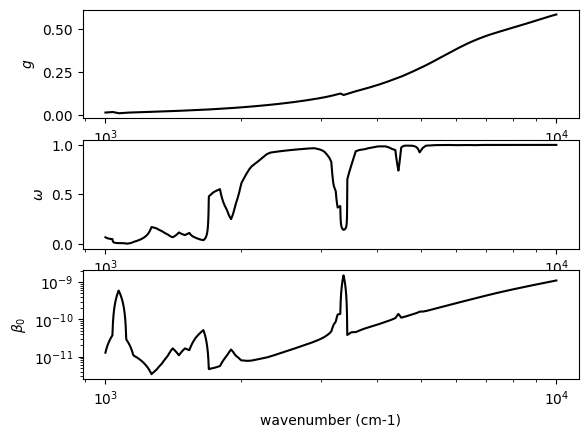

In [9]:
# plt.plot(pdb_nh3.refraction_index_wavenumber, miepar[50,:,0])
fig = plt.figure()
ax = fig.add_subplot(311)
plt.plot(nus, g, color="black")
plt.xscale("log")
plt.ylabel("$g$")
ax = fig.add_subplot(312)
plt.plot(nus, betasct/beta0, label="single scattering albedo", color="black")
plt.xscale("log")
plt.ylabel("$\\omega$")
ax = fig.add_subplot(313)
plt.plot(nus, beta0, label="\\beta_0", color="black")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("wavenumber (cm-1)")
plt.ylabel("$\\beta_0$")
plt.savefig("miefig.png")

## Emission spectrum

### pure absorption

First assume that you'd like to use the emission model with pure absorption, i.e., only the cross section

In [10]:
from exojax.spec.atmrt import ArtEmisPure
art = ArtEmisPure(nu_grid=nus, pressure_btm=1.e2, pressure_top=1.e-3, nlayer=100, rtsolver="ibased", nstream=8) #intesity-based 8stream
#art = ArtEmisPure(nu_grid=nus, pressure_btm=1.e2, pressure_top=1.e-5, nlayer=100, rtsolver="fbased2st") #flux-based

art.change_temperature_range(80.0, 400.0)
Tarr = art.powerlaw_temperature(150.0,0.2)
mmr_profile = art.constant_mmr_profile(0.01)
Parr = art.pressure

from exojax.utils.astrofunc import gravity_jupiter
gravity = gravity_jupiter(1.0,1.0)

rtsolver:  ibased
Intensity-based n-stream solver, isothermal layer (e.g. NEMESIS, pRT like)


In [11]:
mean_molecular_weight = 2.0
xsmatrix = beta0[None,:] + np.zeros((len(art.pressure), len(nus)))
dtau = art.opacity_profile_xs(xsmatrix.real, VMRc, mean_molecular_weight, gravity)


(100, 10000) (100,)


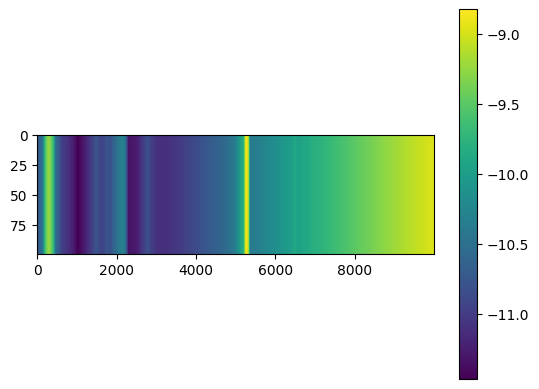

In [12]:
print(np.shape(xsmatrix), np.shape(VMRc))

import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
c=plt.imshow(np.log10(xsmatrix.real))
ax.set_aspect(0.3/ax.get_data_ratio())
plt.colorbar(c)

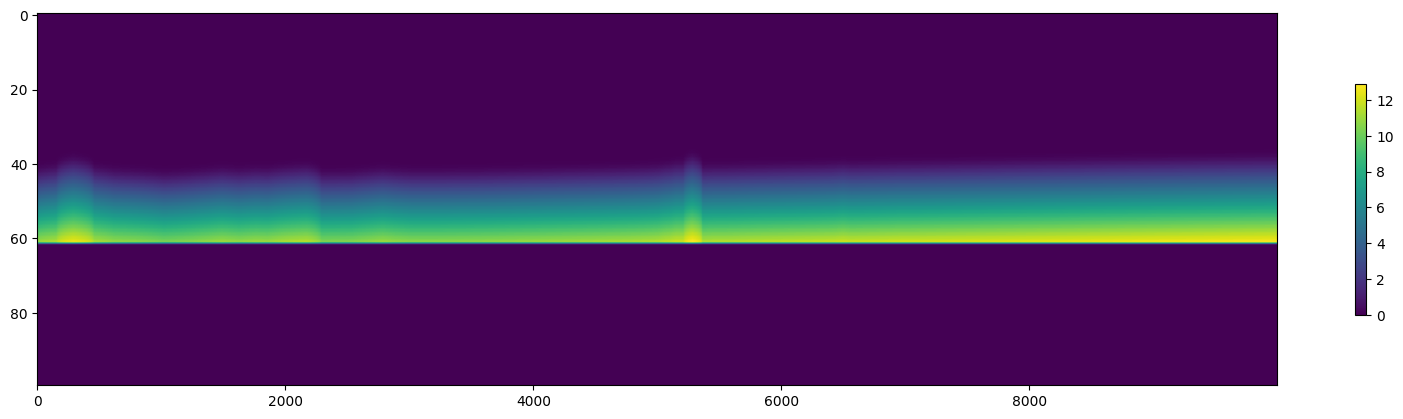

In [13]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
c=plt.imshow(np.log10(dtau+1.0))
ax.set_aspect(0.3/ax.get_data_ratio())
plt.colorbar(c, shrink=0.3)

/home/kawahara/exojax/src/exojax/plot/atmplot.py:108: RuntimeWarning: overflow encountered in expm1
  / np.expm1(hcperk * nus / Tarr[:, None])


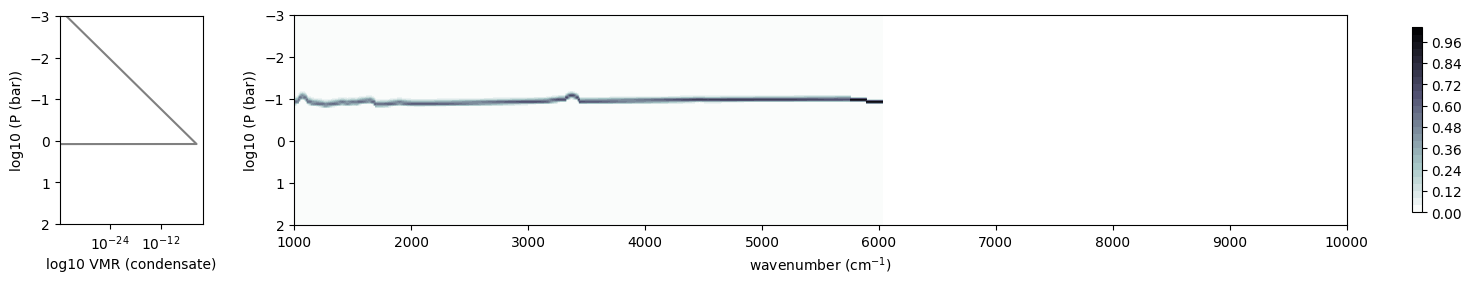

In [14]:
from exojax.plot.atmplot import plotcf

cf = plotcf(
    nus, dtau, Tarr, art.pressure, art.dParr, optarr=VMRc, leftxlabel="log10 VMR (condensate)", leftxlog=True
)

In [41]:
F = art.run(dtau, Tarr, nu_grid=nus)
    

Gaussian Quadrature Parameters: 
mu =  [0.06943184 0.33000948 0.66999052 0.93056816]
weight = [0.17392742 0.32607258 0.32607258 0.17392742]


### with Scattering

In [42]:
from exojax.spec.atmrt import ArtEmisScat
arts = ArtEmisScat(nu_grid=nus, pressure_btm=1.e2, pressure_top=1.e-5, nlayer=100)
arts.change_temperature_range(80.0, 500.0)
Tarr = arts.powerlaw_temperature(200.0,0.2)
mmr_profile = arts.constant_mmr_profile(0.01)

artsl = ArtEmisScat(nu_grid=nus, pressure_btm=1.e2, pressure_top=1.e-5, nlayer=100, rtsolver="lart_toon_hemispheric_mean")
artsl.change_temperature_range(80.0, 500.0)
Tarr = artsl.powerlaw_temperature(200.0,0.2)
mmr_profile = artsl.constant_mmr_profile(0.01)



In [43]:
#dtau = arts.opacity_profile_xs(xsmatrix, VMRc, mean_molecular_weight, gravity)
#
#single_scattering_albedo = betasct[None,:]/beta0[None,:] + np.zeros((len(art.pressure), len(nus)))
#asymmetric_parameter = g + np.zeros((len(art.pressure), len(nus)))
#reflectivity_surface = np.zeros(len(nus))
#incoming_flux = np.ones(len(nus))
#Fs = arts.run(dtau,single_scattering_albedo,asymmetric_parameter,Tarr)
#Fsl = artsl.run(dtau,np.real(single_scattering_albedo),np.real(asymmetric_parameter),Tarr,show=True)
    

In [44]:
#plt.plot(nus,F,label="no scattering")
#plt.plot(nus,Fs,label="with scattering")
#plt.plot(nus,Fsl,label="with scattering")

#plt.legend()

#plt.xscale("log")
#plt.yscale("log")
#plt.ylabel("flux")
#plt.xlabel("wavenumber (cm-1)")

## Reflection spectrum

In [16]:
from exojax.spec.atmrt import ArtReflectPure
artr = ArtReflectPure(nu_grid=nus, pressure_btm=1.e2, pressure_top=1.e-3, nlayer=100)
artr.change_temperature_range(80.0, 400.0)
Tarr = artr.powerlaw_temperature(150.0,0.2)
mmr_profile = artr.constant_mmr_profile(0.01)


In [17]:
dtau = artr.opacity_profile_xs(xsmatrix, VMRc, mean_molecular_weight, gravity)

single_scattering_albedo = betasct[None,:]/beta0[None,:] + np.zeros((len(art.pressure), len(nus)))
asymmetric_parameter = g + np.zeros((len(art.pressure), len(nus)))
reflectivity_surface = np.zeros(len(nus))
incoming_flux = np.ones(len(nus))
Fr = artr.run(dtau,single_scattering_albedo,asymmetric_parameter,reflectivity_surface,incoming_flux)
    

Text(0.5, 0, 'wavenumber (cm-1)')

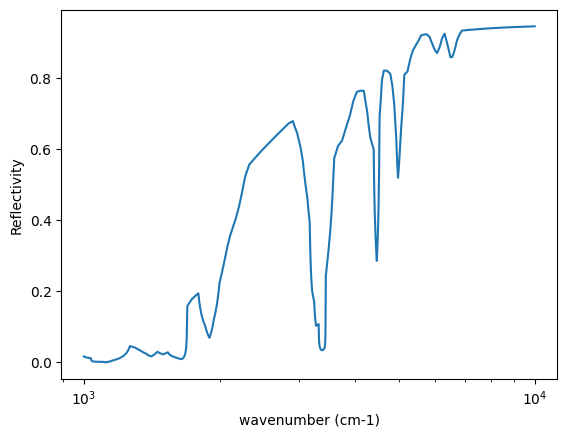

In [18]:
plt.plot(nus,Fr)
plt.xscale("log")
plt.ylabel("Reflectivity")
plt.xlabel("wavenumber (cm-1)")